# Capuchinbird Sound Analysis: Exploratory Data Analysis
This notebook explores audio data to distinguish between Capuchinbird calls and other environmental sounds. We'll analyze audio features, visualize spectrograms, and extract MFCC features for machine learning applications.

## Setup and Configuration

The notebook begins by importing essential libraries for audio processing (librosa), data analysis (numpy, pandas), visualization (matplotlib, seaborn), and machine learning (sklearn). A configuration class is created to store parameters for data paths, feature extraction settings, and visualization properties.

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [37]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 6]

In [38]:
class Config:
    """Configuration class to store all parameters"""
    def __init__(self):
        # Data parameters
        self.audio_extensions = [".mp3", ".wav", ".ogg"]
        self.capuchin_path = os.path.join('data', 'Parsed_Capuchinbird_Clips')
        self.not_capuchin_path = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
        
        # Feature extraction parameters
        self.sr = 22050  # Sampling rate
        self.n_mfcc = 40  # Number of MFCCs
        self.n_mels = 128  # Number of Mel bands
        self.max_samples = 50  # Maximum number of samples to analyze for each class
        
        # Visualization parameters
        self.cmap = 'plasma'
        self.figsize = (12, 6)

# Create config instance
config = Config()

## Data Loading and Preprocessing
Audio files are loaded from two directories: Capuchinbird calls and non-Capuchinbird sounds. Basic properties like duration, sample rate, and amplitude statistics are extracted to understand the general characteristics of each class.

In [39]:
def get_audio_files(path, max_files=None):
    """Get list of audio files in the specified directory"""
    if not os.path.isdir(path):
        print(f"Directory not found: {path}")
        return []
    
    audio_files = [f for f in os.listdir(path) if any(f.endswith(ext) for ext in config.audio_extensions)]
    
    if max_files and len(audio_files) > max_files:
        audio_files = audio_files[:max_files]
    
    return [os.path.join(path, f) for f in audio_files]

In [40]:
capuchin_files_total = get_audio_files(config.capuchin_path)
print(f"Total Capuchinbird audio files are : {len(capuchin_files_total)}")
not_capuchin_files_total = get_audio_files(config.not_capuchin_path)
print(f"Total non-Capuchinbird audio files are : {len(not_capuchin_files_total)}")

Total Capuchinbird audio files are : 217
Total non-Capuchinbird audio files are : 593


In [41]:
capuchin_files = get_audio_files(config.capuchin_path, config.max_samples)
not_capuchin_files = get_audio_files(config.not_capuchin_path, config.max_samples)

In [42]:
print(f"Chosen {len(capuchin_files)} Capuchinbird audio files for analysis")
print(f"Chosen {len(not_capuchin_files)} non-Capuchinbird audio files for analysis")

Chosen 50 Capuchinbird audio files for analysis
Chosen 50 non-Capuchinbird audio files for analysis


## Basic Audio Analysis

This section examines fundamental properties of the audio files, including duration distribution, zero-crossing rates, and amplitude statistics. The histograms and statistical summaries highlight key differences between Capuchinbird calls and other sounds, providing insights for feature engineering.

In [43]:
def extract_audio_properties(file_path):
    """Extract basic properties of an audio file"""
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        
        # Calculate basic properties
        mean = np.mean(y)
        std = np.std(y)
        rms = np.sqrt(np.mean(y**2))
        max_amp = np.max(np.abs(y))
        
        # Calculate zero crossing rate
        zero_crossings = librosa.feature.zero_crossing_rate(y)[0]
        
        return {
            'file': os.path.basename(file_path),
            'class': 'capuchin' if 'Capuchinbird' in file_path else 'not_capuchin',
            'duration': duration,
            'sample_rate': sr,
            'num_samples': len(y),
            'mean': mean,
            'std': std,
            'rms': rms,
            'max_amplitude': max_amp,
            'zero_crossing_rate': np.mean(zero_crossings)
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [44]:
audio_properties = []

print("Analyzing Capuchinbird files...")
for file in tqdm(capuchin_files):
    props = extract_audio_properties(file)
    if props:
        audio_properties.append(props)

print("Analyzing non-Capuchinbird files...")
for file in tqdm(not_capuchin_files):
    props = extract_audio_properties(file)
    if props:
        audio_properties.append(props)

audio_df = pd.DataFrame(audio_properties)

Analyzing Capuchinbird files...


100%|██████████| 50/50 [00:00<00:00, 52.82it/s]


Analyzing non-Capuchinbird files...


100%|██████████| 50/50 [00:01<00:00, 48.27it/s]


In [45]:
print("\nAudio Properties Summary:")
print(audio_df.describe())


Audio Properties Summary:
         duration   sample_rate    num_samples          mean         std  \
count  100.000000    100.000000     100.000000  1.000000e+02  100.000000   
mean     3.231650  45777.000000  148170.750000 -5.725618e-05    0.039024   
std      0.405161   1940.522423   21662.794819  4.005477e-04    0.049409   
min      2.000000  44100.000000   96000.000000 -3.798070e-03    0.003379   
25%      3.010000  44100.000000  134813.000000 -1.335528e-05    0.008499   
50%      3.057982  44100.000000  134858.000000 -1.590801e-07    0.016045   
75%      3.500000  48000.000000  168000.000000  6.992294e-07    0.039885   
max      4.000000  48000.000000  192000.000000  5.345135e-04    0.253902   

              rms  max_amplitude  zero_crossing_rate  
count  100.000000     100.000000          100.000000  
mean     0.039026       0.202958            0.123375  
std      0.049409       0.208121            0.061698  
min      0.003379       0.027039            0.024468  
25%      0.00

## Waveform Visualization
Waveform plots display the audio signal amplitude over time. Capuchinbird calls typically show distinct patterns with powerful, low-frequency booming sounds characterized by their unique rhythmic structure. Non-Capuchinbird samples generally exhibit different temporal patterns.

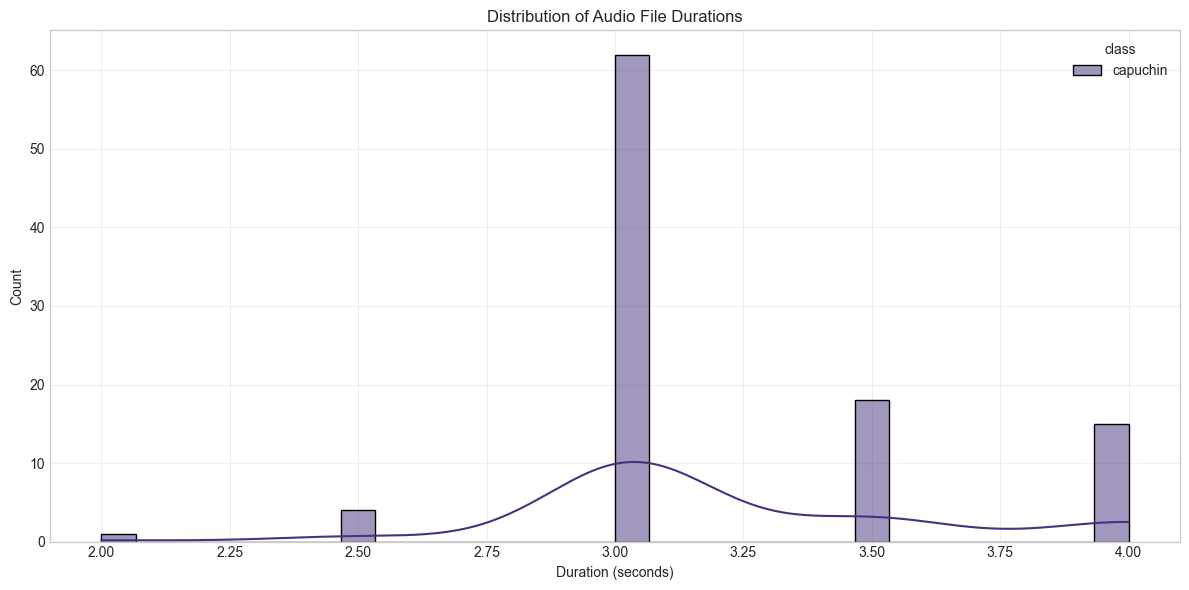

In [46]:
plt.figure(figsize=config.figsize)
sns.histplot(data=audio_df, x='duration', hue='class', bins=30, kde=True)
plt.title('Distribution of Audio File Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [47]:
duration_by_class = audio_df.groupby('class')['duration'].agg(['mean', 'min', 'max', 'std'])
print("\nDuration Statistics by Class:")
print(duration_by_class)


Duration Statistics by Class:
             mean  min  max       std
class                                
capuchin  3.23165  2.0  4.0  0.405161



Capuchinbird Waveform Samples:

Non-Capuchinbird Waveform Samples:


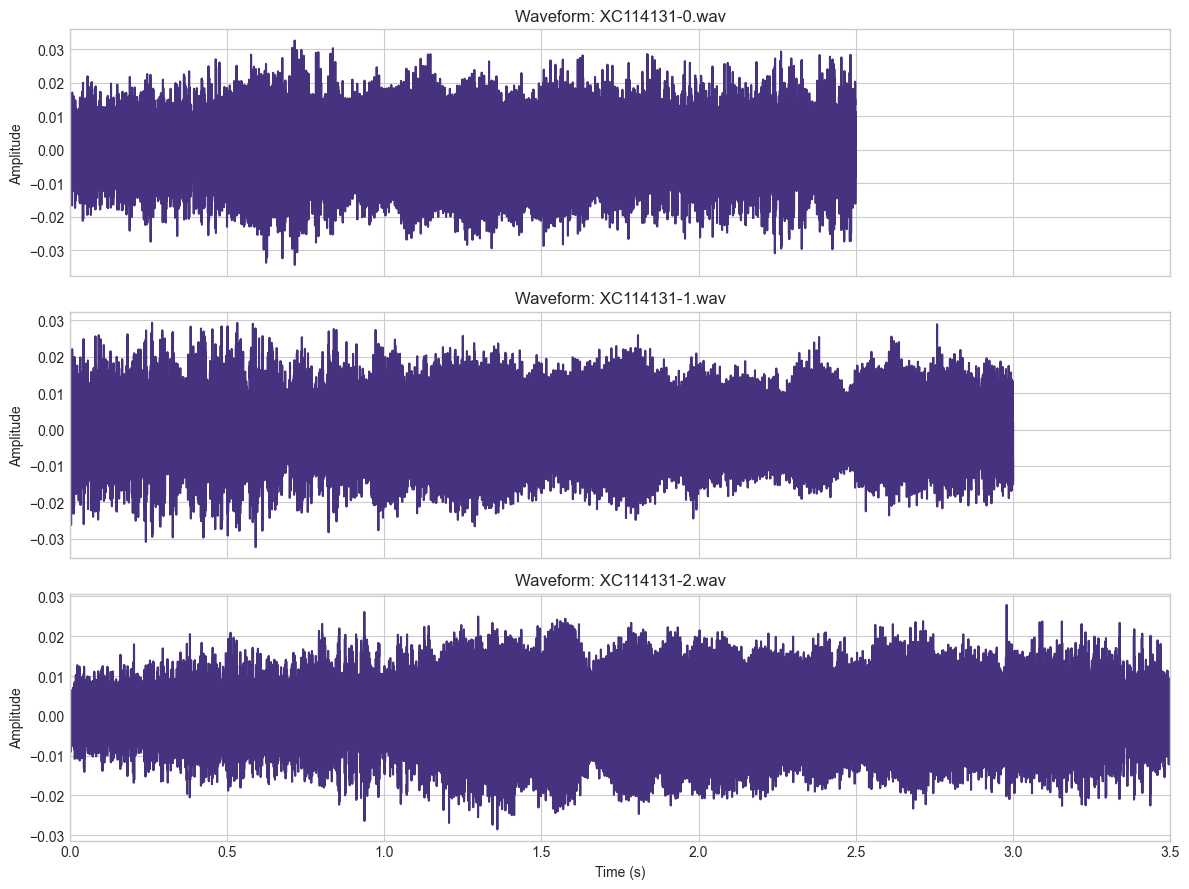

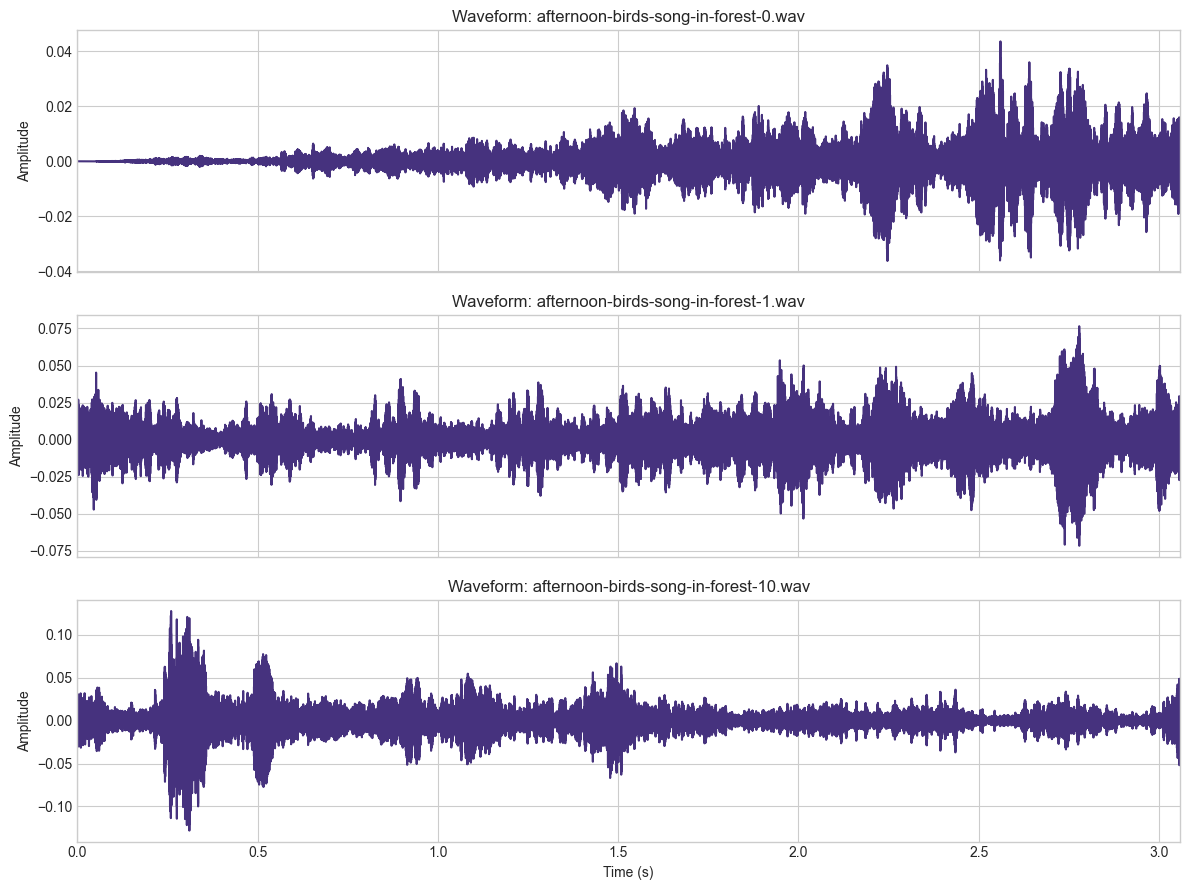

In [48]:
def plot_waveforms(files, n_samples=3):
    """Plot waveforms for a sample of audio files"""
    n_samples = min(n_samples, len(files))
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, n_samples * 3), sharex=True)
    
    if n_samples == 1:
        axes = [axes]
    
    for i, file_path in enumerate(files[:n_samples]):
        y, sr = librosa.load(file_path, sr=config.sr)
        
        axes[i].plot(np.linspace(0, len(y)/sr, len(y)), y)
        axes[i].set_title(f"Waveform: {os.path.basename(file_path)}")
        axes[i].set_ylabel("Amplitude")
        axes[i].set_xlim(0, len(y)/sr)
        
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()

print("\nCapuchinbird Waveform Samples:")
plot_waveforms(capuchin_files, 3)

print("\nNon-Capuchinbird Waveform Samples:")
plot_waveforms(not_capuchin_files, 3)

## Mel Spectrogram Analysis
Mel spectrograms provide a frequency-time representation that approximates human auditory perception. The visualizations reveal the energy distribution across different frequency bands over time, highlighting the distinctive spectral signature of Capuchinbird calls compared to other sounds.

In [49]:
def plot_mel_spectrograms(files, n_samples=3):
    """Plot Mel spectrograms for a sample of audio files"""
    n_samples = min(n_samples, len(files))
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, n_samples * 4), sharex=True)
    
    if n_samples == 1:
        axes = [axes]
    
    for i, file_path in enumerate(files[:n_samples]):
        y, sr = librosa.load(file_path, sr=config.sr)
        
        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_mels=config.n_mels,
            fmax=sr/2
        )
        
        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Plot
        img = librosa.display.specshow(
            mel_spec_db, 
            x_axis='time', 
            y_axis='mel', 
            sr=sr,
            fmax=sr/2,
            ax=axes[i],
            cmap=config.cmap
        )
        
        axes[i].set_title(f"Mel Spectrogram: {os.path.basename(file_path)}")
        
    # Add colorbar to the last axis
    plt.tight_layout()


Capuchinbird Mel Spectrogram Samples:


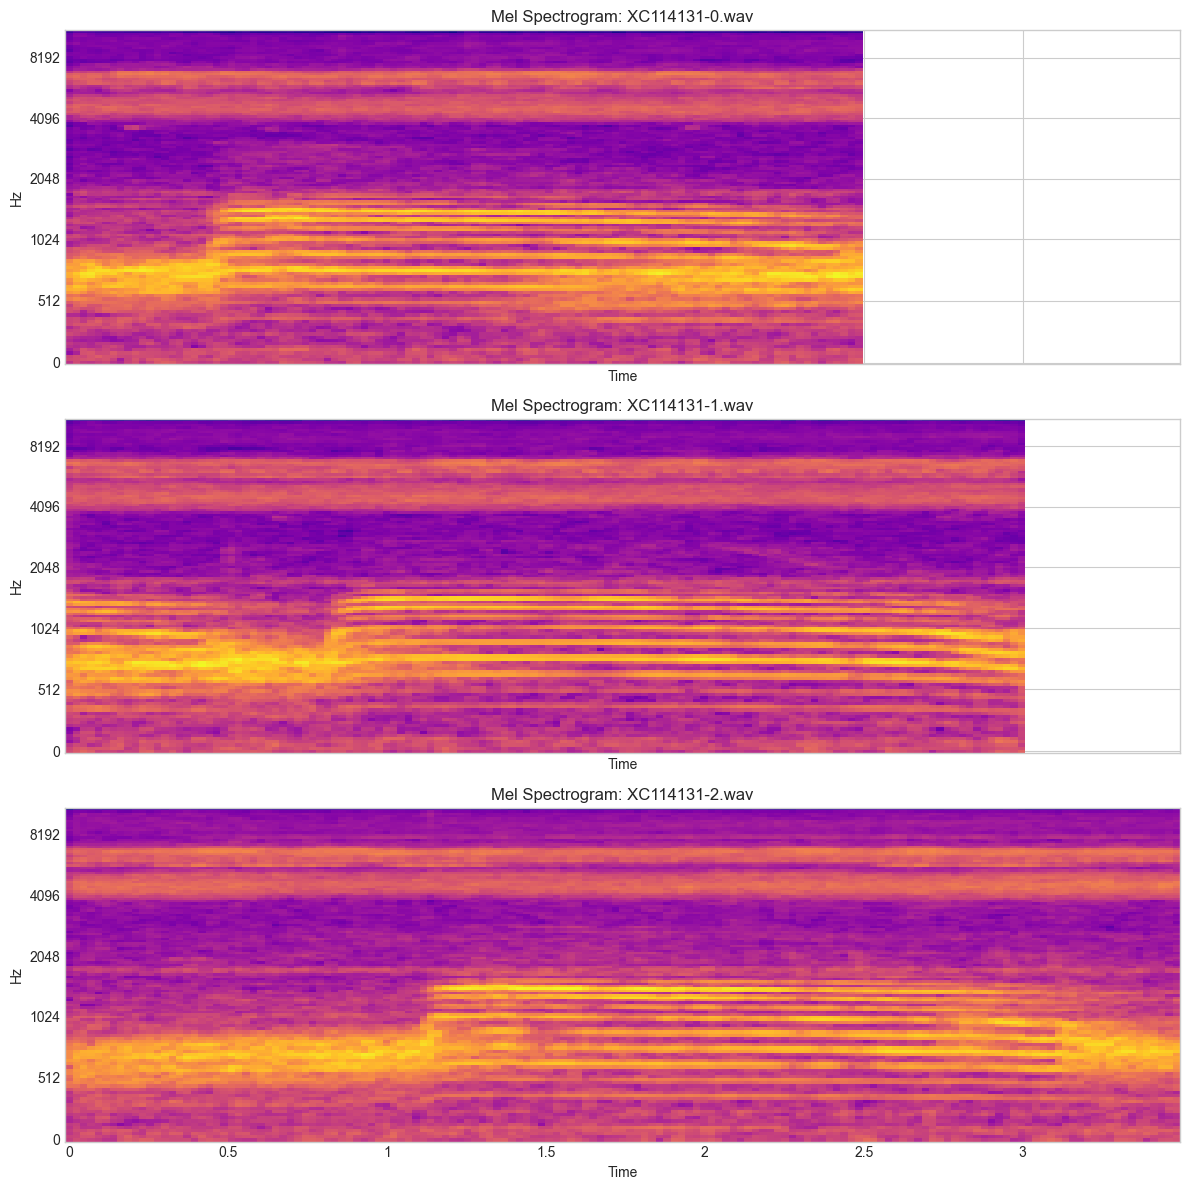

In [50]:
print("\nCapuchinbird Mel Spectrogram Samples:")
plot_mel_spectrograms(capuchin_files, 3)


Non-Capuchinbird Mel Spectrogram Samples:


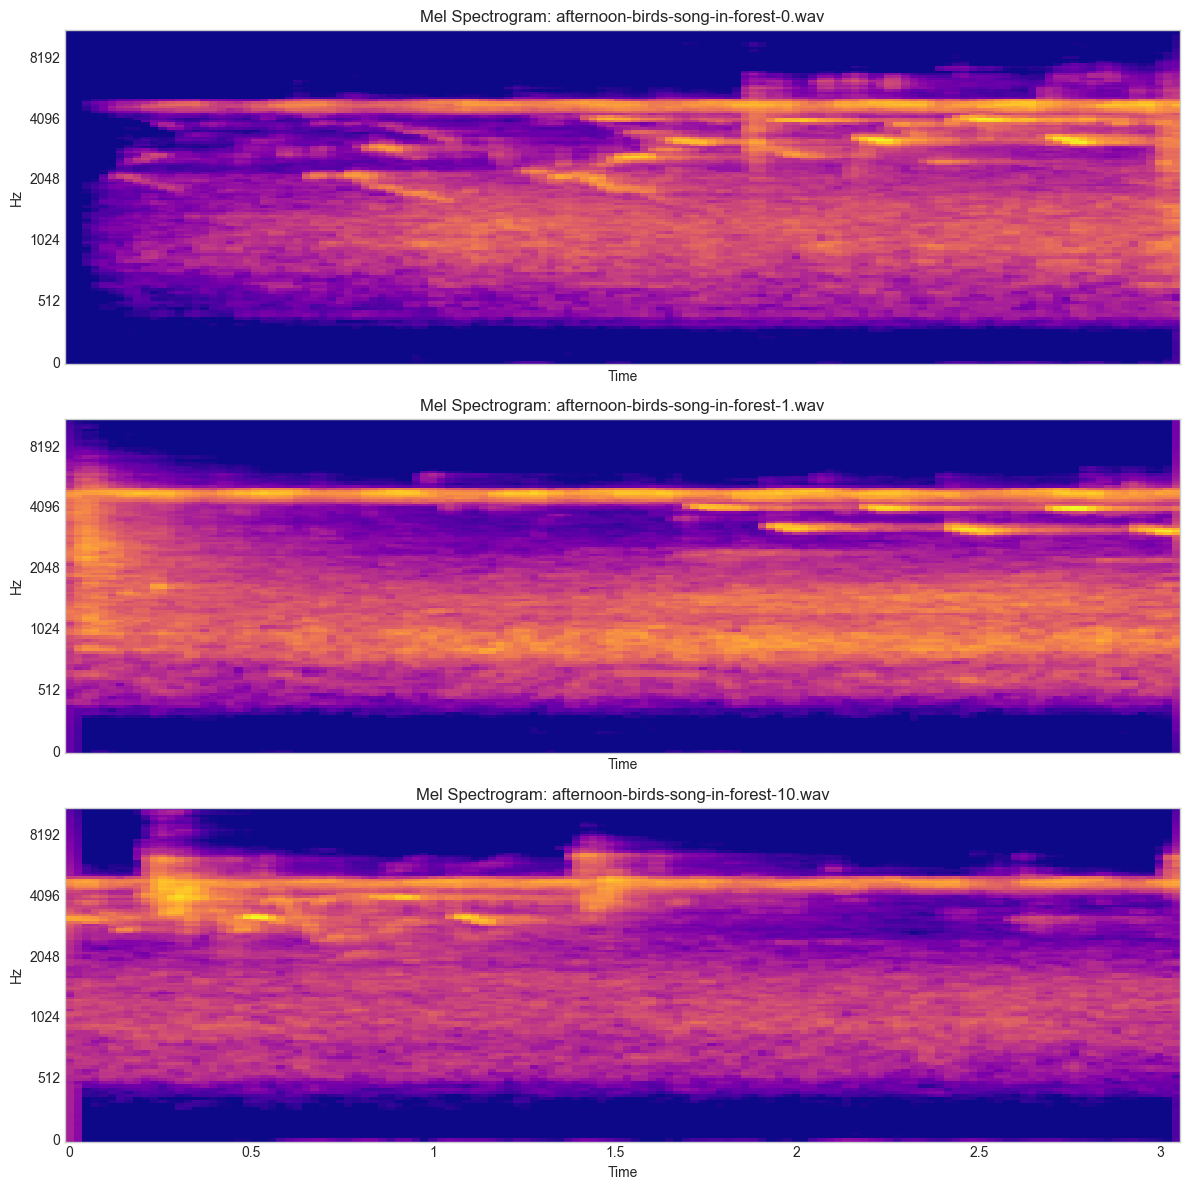

In [51]:
print("\nNon-Capuchinbird Mel Spectrogram Samples:")
plot_mel_spectrograms(not_capuchin_files, 3)

## Statistical Analysis of MFCC Features

Mel-Frequency Cepstral Coefficients (MFCCs) are powerful features for audio classification. This section extracts MFCCs alongside their delta (first derivative) and delta-delta (second derivative) components to capture both static and dynamic aspects of the audio. The preprocessing steps include silence trimming and normalization to enhance feature quality.

In [52]:
def extract_mfccs(file_path):
    """Extract MFCCs from an audio file with improved preprocessing"""
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=config.sr)
        
        # Trim silent parts
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # Normalize audio
        y = librosa.util.normalize(y)
        
        # Extract MFCCs with more coefficients and delta features for better differentiation
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.n_mfcc)
        
        # Add delta features to capture temporal dynamics
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        
        # Combine features
        mfcc_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])
        
        return mfcc_features, os.path.basename(file_path)
    except Exception as e:
        print(f"Error extracting MFCCs from {file_path}: {e}")
        return None, None

In [53]:
def plot_mfccs(files, n_samples=3):
    """Plot MFCCs for a sample of audio files"""
    n_samples = min(n_samples, len(files))
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, n_samples * 4), sharex=True)
    
    if n_samples == 1:
        axes = [axes]
    
    # Find global min and max for consistent color scaling
    all_mfccs = []
    for file_path in files[:n_samples]:
        mfccs, _ = extract_mfccs(file_path)
        if mfccs is not None:
            all_mfccs.append(mfccs)
    
    vmin = min(np.min(mfcc) for mfcc in all_mfccs) if all_mfccs else None
    vmax = max(np.max(mfcc) for mfcc in all_mfccs) if all_mfccs else None
    
    # Keep track of the last valid img for colorbar
    last_img = None
    
    for i, file_path in enumerate(files[:n_samples]):
        mfccs, filename = extract_mfccs(file_path)
        
        if mfccs is not None:
            img = librosa.display.specshow(
                mfccs, 
                x_axis='time',
                ax=axes[i],
                cmap=config.cmap,
                vmin=vmin,
                vmax=vmax
            )
            axes[i].set_title(f"MFCCs: {filename}")
            # Update last valid image for colorbar
            last_img = img
            
            # Add y-axis labels to show coefficient numbers
            axes[i].set_ylabel('MFCC Coefficients')
            
            # Add grid for better visual reference
            axes[i].grid(True, alpha=0.3, linestyle='--')
    
    
    # Add overall x-axis label
    if n_samples > 0:
        axes[-1].set_xlabel('Time (frames)')
    
    plt.tight_layout()
    plt.suptitle('MFCC Visualization with Enhanced Features', y=1.02, fontsize=16)
    plt.subplots_adjust(top=0.95)  # Make room for the title
    
    return fig, axes


Capuchinbird MFCC Samples:


(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'MFCCs: XC114131-0.wav'}, xlabel='Time', ylabel='MFCC Coefficients'>,
        <Axes: title={'center': 'MFCCs: XC114131-1.wav'}, xlabel='Time', ylabel='MFCC Coefficients'>,
        <Axes: title={'center': 'MFCCs: XC114131-2.wav'}, xlabel='Time (frames)', ylabel='MFCC Coefficients'>],
       dtype=object))

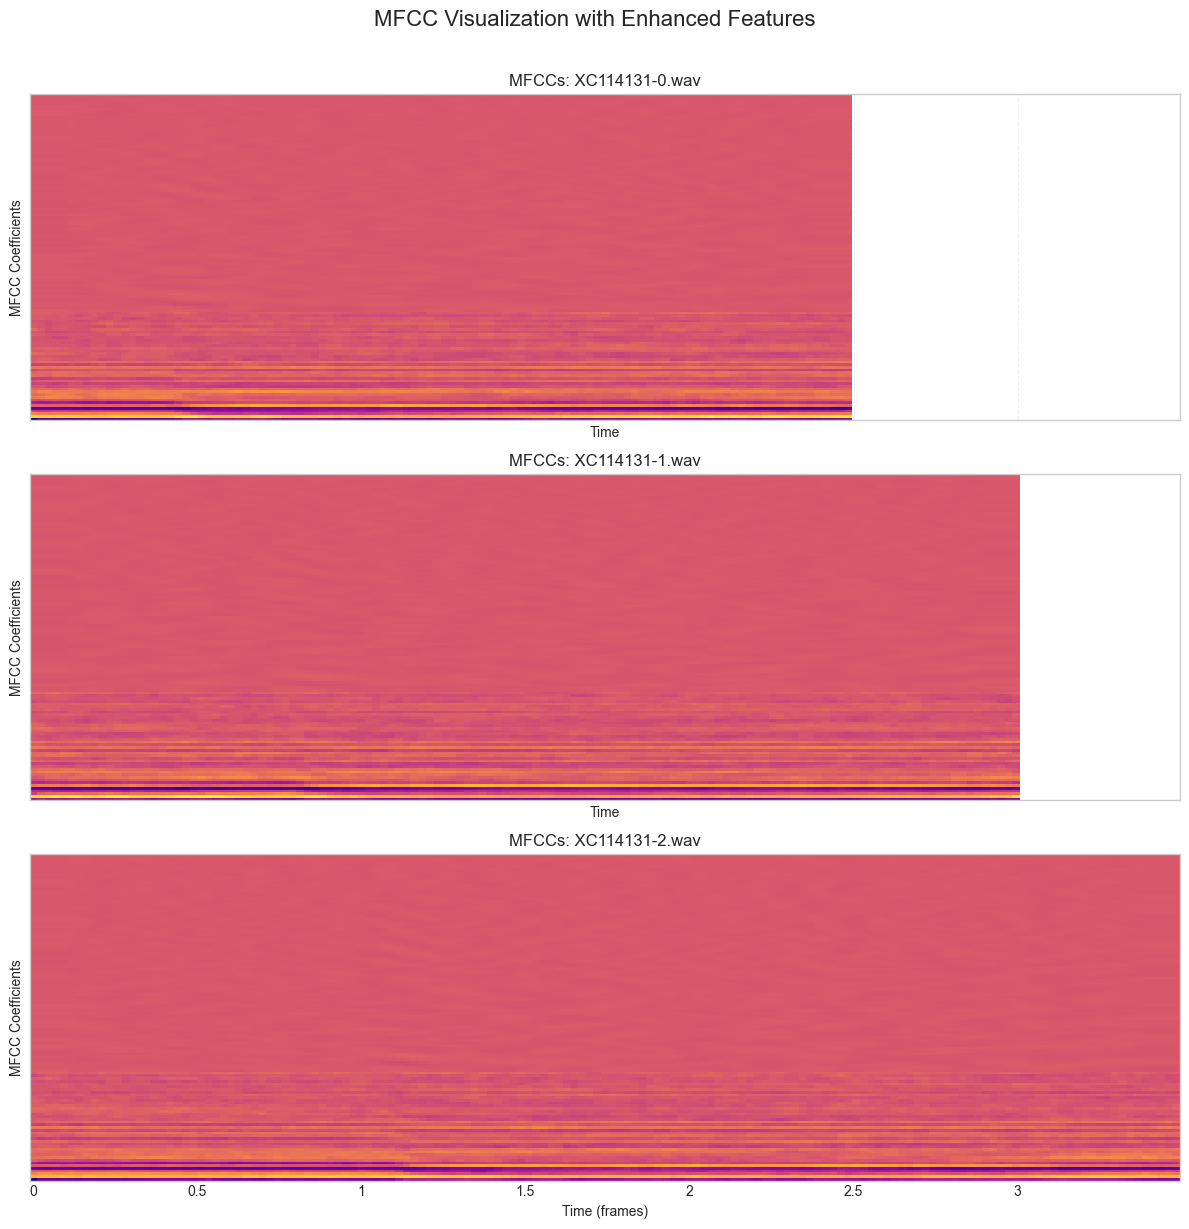

In [54]:
print("\nCapuchinbird MFCC Samples:")
plot_mfccs(capuchin_files, 3)


Non-Capuchinbird MFCC Samples:


(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'MFCCs: afternoon-birds-song-in-forest-0.wav'}, xlabel='Time', ylabel='MFCC Coefficients'>,
        <Axes: title={'center': 'MFCCs: afternoon-birds-song-in-forest-1.wav'}, xlabel='Time', ylabel='MFCC Coefficients'>,
        <Axes: title={'center': 'MFCCs: afternoon-birds-song-in-forest-10.wav'}, xlabel='Time (frames)', ylabel='MFCC Coefficients'>],
       dtype=object))

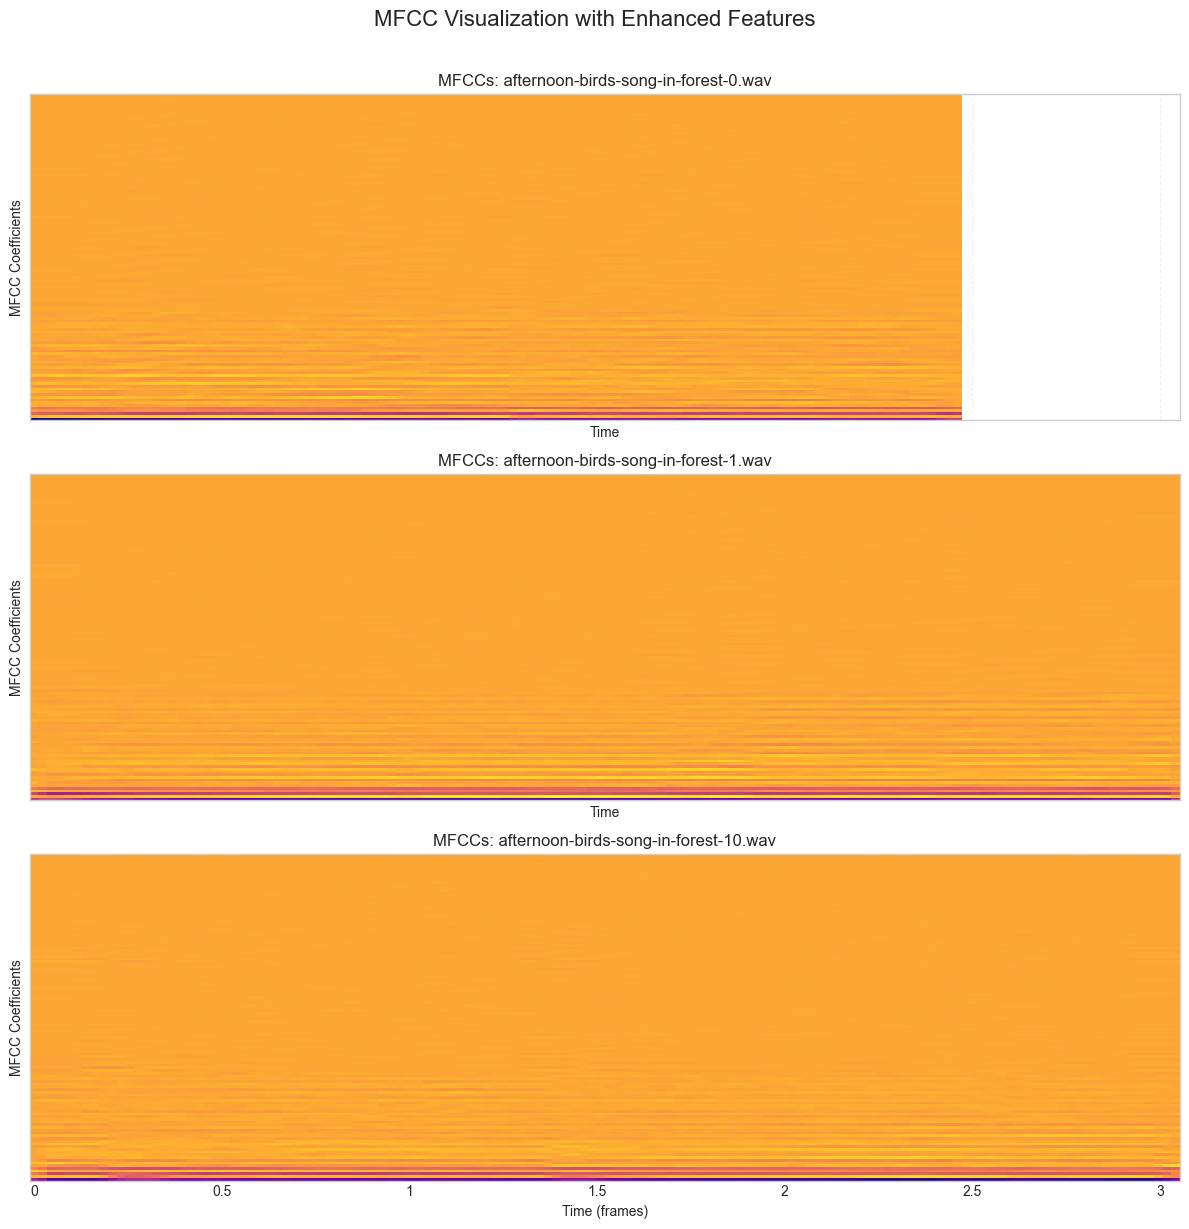

In [55]:
print("\nNon-Capuchinbird MFCC Samples:")
plot_mfccs(not_capuchin_files, 3)

## Statistical Analysis of MFCC Features
Principal Component Analysis (PCA) reduces the high-dimensional MFCC feature space to two principal components for visualization. The scatter plot shows the separation between Capuchinbird and non-Capuchinbird samples in this reduced feature space, demonstrating the effectiveness of MFCC features for this classification task.

In [56]:
def extract_mfcc_stats(files):
    """Extract statistics from MFCCs for each audio file"""
    mfcc_stats = []
    
    for file_path in tqdm(files):
        mfccs, _ = extract_mfccs(file_path)
        
        if mfccs is not None:
            # Get statistics across time for each MFCC coefficient
            mfcc_mean = np.mean(mfccs, axis=1)
            mfcc_std = np.std(mfccs, axis=1)
            mfcc_min = np.min(mfccs, axis=1)
            mfcc_max = np.max(mfccs, axis=1)
            
            # Create a record for each file
            record = {
                'file': os.path.basename(file_path),
                'class': 'capuchin' if 'Capuchinbird' in file_path else 'not_capuchin'
            }
            
            # Add statistics for each MFCC coefficient
            for i in range(config.n_mfcc):
                record[f'mfcc{i+1}_mean'] = mfcc_mean[i]
                record[f'mfcc{i+1}_std'] = mfcc_std[i]
                
            mfcc_stats.append(record)
    
    return pd.DataFrame(mfcc_stats)

In [57]:
print("\nExtracting MFCC statistics...")
mfcc_stats_df = extract_mfcc_stats(capuchin_files + not_capuchin_files)


Extracting MFCC statistics...


100%|██████████| 100/100 [00:01<00:00, 58.20it/s]


In [58]:
print(f"\nMFCC Statistics Shape: {mfcc_stats_df.shape}")
print(mfcc_stats_df.head())


MFCC Statistics Shape: (100, 82)
             file     class  mfcc1_mean  mfcc1_std  mfcc2_mean  mfcc2_std  \
0  XC114131-0.wav  capuchin  -56.814297  11.074503   66.964897   9.492441   
1  XC114131-1.wav  capuchin  -58.973206   9.359078   57.770966  13.908492   
2  XC114131-2.wav  capuchin  -50.225704  11.782058   56.465420   6.673381   
3  XC114131-3.wav  capuchin  -65.569092   9.780046   49.853474   6.369222   
4  XC114131-4.wav  capuchin  -61.667038  11.103964   53.833546   7.969233   

   mfcc3_mean  mfcc3_std  mfcc4_mean  mfcc4_std  ...  mfcc36_mean  mfcc36_std  \
0    6.308139  16.736345  -31.727041   8.430223  ...     3.206050    3.520283   
1    4.944302  12.436479  -29.778513   6.158205  ...     5.633586    2.913074   
2   10.200569  18.697287  -22.841761  14.779467  ...     2.717476    3.790688   
3   -1.007866  15.181957  -21.155655  12.271514  ...     2.819051    2.656206   
4    1.956005  14.408998  -18.203695  16.765310  ...     1.821240    3.904479   

   mfcc37_mean  

In [59]:
mfcc_means = mfcc_stats_df.groupby('class')[[col for col in mfcc_stats_df.columns if 'mean' in col]].mean().T
mfcc_means.index = [idx.split('_')[0] for idx in mfcc_means.index]

<Figure size 1200x600 with 0 Axes>

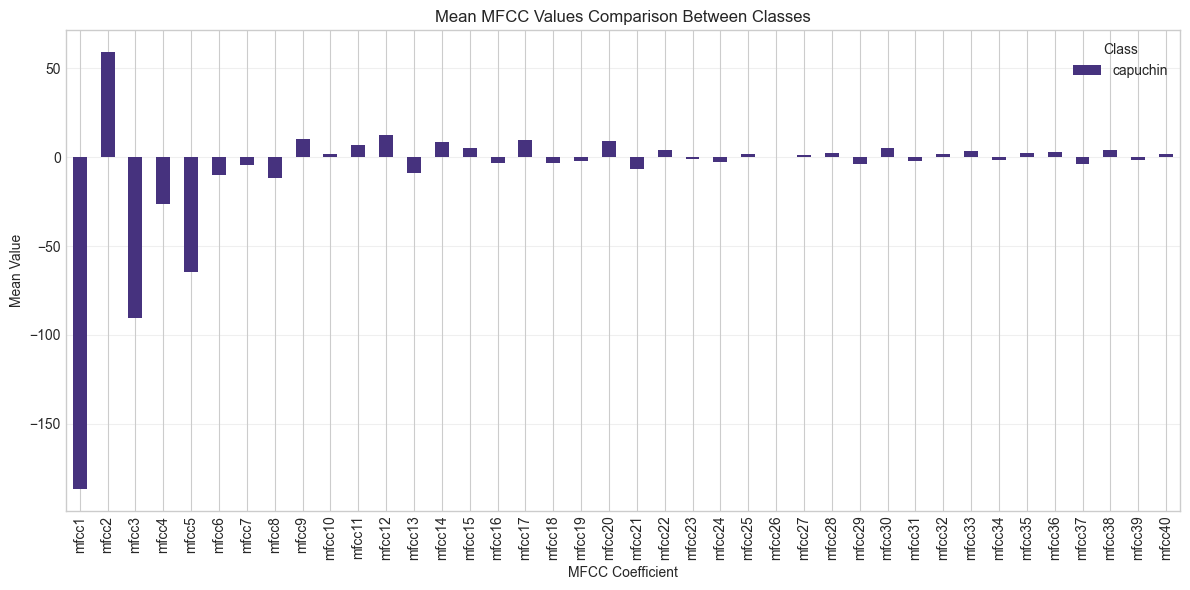

In [60]:
plt.figure(figsize=config.figsize)
mfcc_means.plot(kind='bar', figsize=config.figsize)
plt.title('Mean MFCC Values Comparison Between Classes')
plt.ylabel('Mean Value')
plt.xlabel('MFCC Coefficient')
plt.legend(title='Class')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

## Dimensionality Reduction with PCA

Principal Component Analysis (PCA) reduces the high-dimensional MFCC feature space to two principal components for visualization. The scatter plot shows the separation between Capuchinbird and non-Capuchinbird samples in this reduced feature space, demonstrating the effectiveness of MFCC features for this classification task.

In [61]:
mfcc_features = mfcc_stats_df[[col for col in mfcc_stats_df.columns if col.startswith('mfcc')]]

# Standardize features
scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(mfcc_features)

In [62]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mfcc_scaled)

# Create dataframe for plotting
pca_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'class': mfcc_stats_df['class']
})

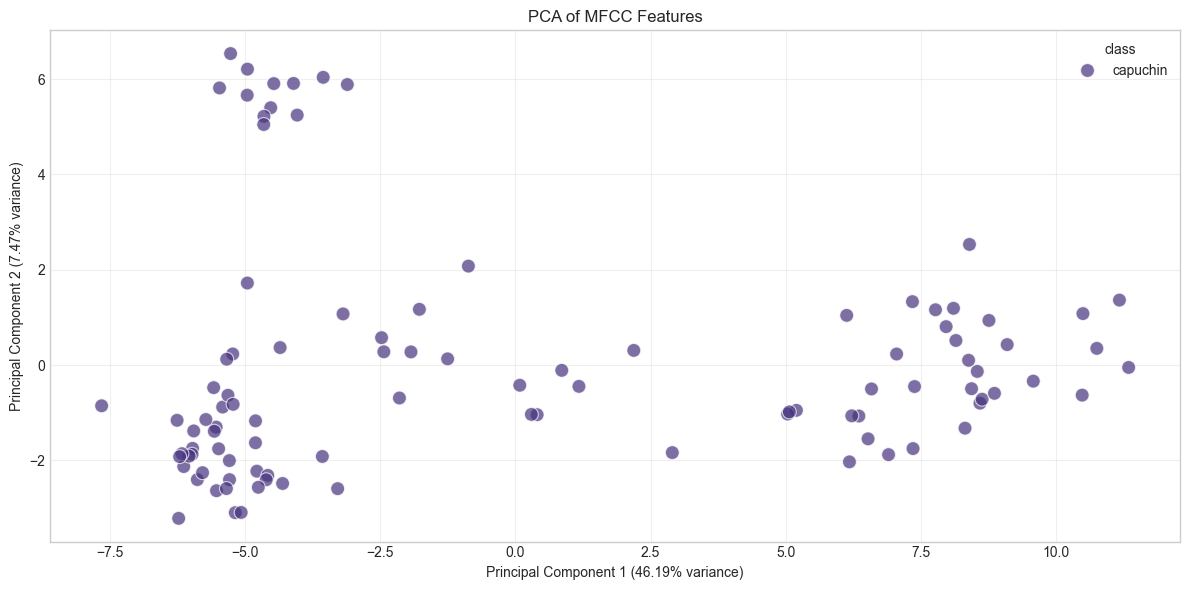

In [63]:
plt.figure(figsize=config.figsize)
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', s=100, alpha=0.7)
plt.title('PCA of MFCC Features')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()


## Conclusion

The exploratory analysis reveals clear acoustic differences between Capuchinbird calls and other sounds. The MFCC features, particularly when visualized through PCA, show promising separation between classes. This suggests that deep learning models using these features could effectively identify Capuchinbird calls in audio recordings.